### Import / load files

In [1]:
import torch
import torchvision
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import sys
%matplotlib inline

useGPU = torch.cuda.is_available()

In [2]:
# first we load the data
features_PCA = torch.load('PCA-features.pt')
features_PCA


-8.4063e+00 -7.1521e+00 -7.8016e-01  ...  -8.8180e-01 -5.0255e-01 -7.2228e-01
-6.5140e+00  4.4774e+00  4.4884e+00  ...  -9.5864e-01 -1.0499e-01  7.2858e-01
-3.1564e+00  5.3898e+00  3.1564e+00  ...   6.6038e-01 -1.3145e+00 -4.5129e-01
                ...                   ⋱                   ...                
-7.3145e+00 -4.8327e+00 -2.5488e+00  ...   9.1882e-01 -6.7384e-01 -9.3270e-02
 4.9693e+00 -4.6637e-01  9.9329e+00  ...  -2.1649e-01 -4.1381e-01 -1.1081e+00
-2.6722e+00 -1.2596e+00  4.2186e+00  ...   8.1245e-01  1.0686e+00  3.6901e-01
[torch.cuda.FloatTensor of size 5000x128 (GPU 0)]

In [12]:
# load the corresponding captions
with open('captions.pkl', 'rb') as f:
    captions_list = pickle.load(f)
    
captions_list[0:3]

[['A group of horses are grazing in the field.',
  'Three horse running in the grass in a open area.',
  'Three horse running through an open muddy field.',
  'A herd of three horses standing on top of a green field.',
  'some horse running around in a field '],
 ['A large passenger jet sitting on top of an airport runway.',
  'A large commercial airplane sitting on a runway',
  'An airplane makes its way down a snowy runway.',
  'A plane siting on a showy tarmac at an airport',
  'A jet is towed down the tarmac on a dreary gray day.'],
 ['An airplane on the runway either just landed or ready to take off.',
  'An Egyptian airlines plane landing at an airport.',
  'A commercial plane on the strip to take off.',
  'A jumbo jet touching down on the runway.',
  'Egyptair airplane standing on the tarmac at airport']]

In [4]:
len(captions_list)

5000

In [13]:
# load the corresponding images
images = torch.load('images.pt')
images.size()

torch.Size([5000, 3, 224, 224])

In [6]:
# load the raw features
raw_features = torch.load('raw-features.pt')
raw_features


 0.1522  0.0855  0.3179  ...   0.0077  0.0138  0.2809
 0.0747  0.0256  0.2285  ...   0.0670  0.2206  0.0213
 0.2154  0.3533  0.0603  ...   0.3864  0.0568  0.0324
          ...             ⋱             ...          
 0.0671  0.0989  0.0113  ...   0.2617  0.7807  0.6469
 0.2934  0.1945  0.9250  ...   0.1170  0.4070  0.1099
 0.0439  0.1702  0.4204  ...   1.7394  0.2452  0.1753
[torch.cuda.FloatTensor of size 5000x512 (GPU 0)]

### First quick sanity check of the loaded files

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # .numpy() Returns this tensor as a NumPy ndarray. 
    # This tensor and the returned ndarray share the same underlying storage. 
    # Changes to this tensor will be reflected in the ndarray and vice versa.
    # .tranpose change the ndarray from 3x228x906 to 228x906x3 -> used probably by imshow)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # reverse the normalization applied
    inp = std * inp + mean
    plt.figure()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

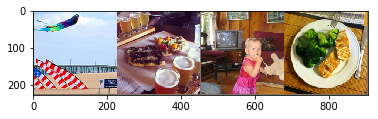

In [8]:
# display a few images to see if it match well with the caption
inputs = images.cpu()[4:8]
out = torchvision.utils.make_grid(inputs, nrow=4)
imshow(out)

In [9]:
captions_list[4:8]

[['Kites being used by people on a beach.',
  'A kite that someone is flying over a beach.',
  'People are standing around while a kite is being flown.',
  'A kite flies over flags posted on a windy beach.',
  'A group of people flying kites on top of a sandy beach.'],
 ['two flatbread pieces covered with different ingredients in between a flight of beers',
  "A table topped with three mugs of beer and two pizza's.",
  'Two small flat breads with beer samplers on each side.',
  'A wooden table holding multiple beers and a plate of food with pizza on it.',
  'A view of a bunch of pizzas sitting on a table.'],
 ['A baby girl chews on a stick with a teddy bear in hand.',
  'A little girl is using the toy brush for a chew toy rather than brushing the teddy.',
  'A young girl plays with a teddy bear and puts a brush in her mouth.',
  'A toddler standing with a brush in her mouth.',
  'A little girl playing with a teddy bear and chewing on a toothbrush.'],
 ['The meal of fish has a side of b

We see that the caption and images seems to match well so we can consider our files fine.

### Implementation of k-NN brute force

In [10]:
def progress(count, total, suffix=''):
    """ Shows the progress of a given action 
    
    @params:
    - count : the current count of done operations
    - total : the total number of operation to do
    - suffix : a message printed after the progress bar
    """
    
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '#' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ... %s\r' % (bar, percents, '%', suffix))
    sys.stdout.flush()

In [14]:
vec = torch.rand(100)
mat = torch.rand(10000,100)

In [16]:
vec.expand(mat.size())


 0.6876  0.7831  0.4633  ...   0.6146  0.4065  0.2050
 0.6876  0.7831  0.4633  ...   0.6146  0.4065  0.2050
 0.6876  0.7831  0.4633  ...   0.6146  0.4065  0.2050
          ...             ⋱             ...          
 0.6876  0.7831  0.4633  ...   0.6146  0.4065  0.2050
 0.6876  0.7831  0.4633  ...   0.6146  0.4065  0.2050
 0.6876  0.7831  0.4633  ...   0.6146  0.4065  0.2050
[torch.FloatTensor of size 10000x100]

In [26]:
def select_all_except_row(tensor, i):
    """
        return all the tensor except the i-th row
        @params:
            - tensor: 2D tensor on which to perform the operation
            - i: the row to drop
        @return:
            - tensor: 2D tensor with the i-th row droped
    """
    if i == 0:
        return tensor[1:]
    elif i == (len(tensor) - 1):
        return tensor[:-1]
    else:
        return torch.cat((tensor[0:i], tensor[i+1:]), 0)

In [39]:
def knn_bruteforce_gpu(tensor, k, with_progress=False):
    """
        Compute a knn list with element being tuples (values, indices) ordered,
        of the k nearest rows for each row of a tensor.
        @params:
            - tensor: 2D tensor on which to perform the algorithm
            - k: the number of nearest neighbor to keep
        @return:
            - knn_list: list of ordered tuples with the value, indices of the k nearest row for each row
    """
    knn_list = []
    for i in range(len(tensor)):
        vec = tensor[i]
        mat = select_all_except_row(tensor, i)
        distances = torch.norm(mat - vec.expand(mat.size()), 2, 1)
        knn_list.append(torch.topk(distances, k, dim=0, largest=False))
        if with_progress:
            progress(i,len(tensor),'Computing k-nn')
    return knn_list

In [40]:
%%time
knn_raw_features_list = knn_bruteforce_gpu(raw_features, 1)

CPU times: user 944 ms, sys: 155 ms, total: 1.1 s
Wall time: 1.09 s


In [41]:
%%time
knn_features_pca_list = knn_bruteforce_gpu(features_PCA, 1)

CPU times: user 652 ms, sys: 7.36 ms, total: 660 ms
Wall time: 650 ms


In [42]:
# save the 2 list in a pickle file for quick load
with open('knn_raw_features_list.pkl', 'wb') as f:
    pickle.dump(knn_raw_features_list, f)
    
with open('knn_features_pca_list.pkl', 'wb') as f:
    pickle.dump(knn_features_pca_list, f)

### Checking the results

#### Quick visual check for the 10 first pair

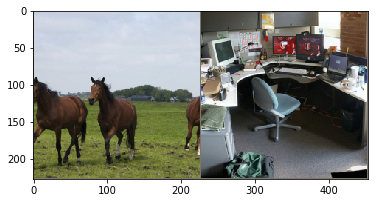

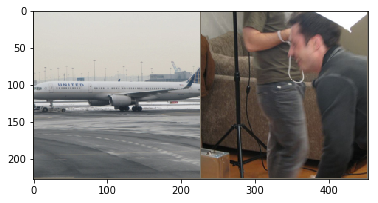

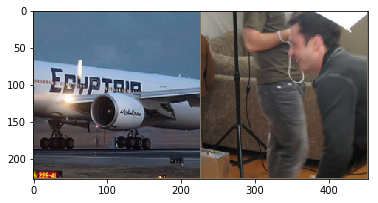

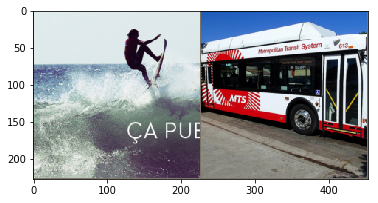

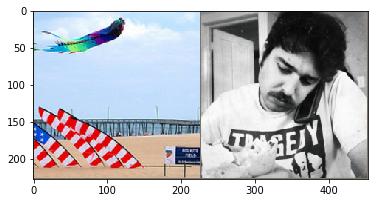

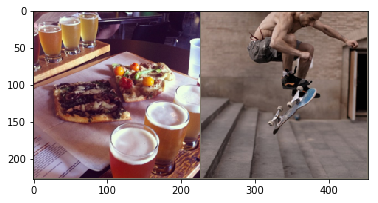

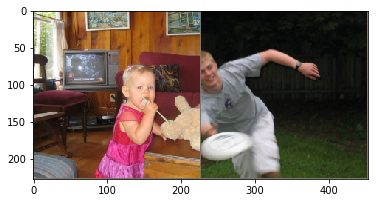

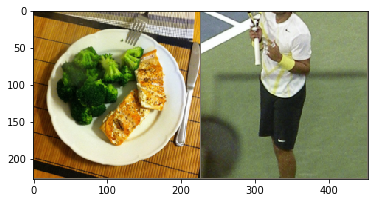

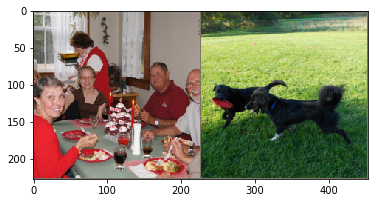

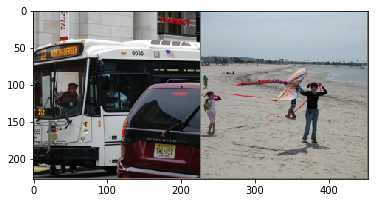

In [48]:
# for the raw features
for idx, tuples in enumerate(knn_raw_features_list[0:10]):
    inputs = torch.FloatTensor(2,3,224,224)
    inputs[0] = images[idx].cpu()
    inputs[1] = images[tuples[1].cpu().numpy()[0]].cpu()
    out = torchvision.utils.make_grid(inputs, nrow=2)
    imshow(out)

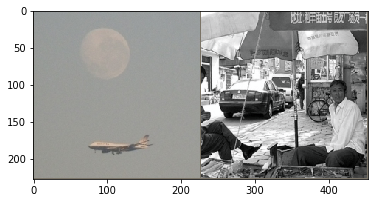

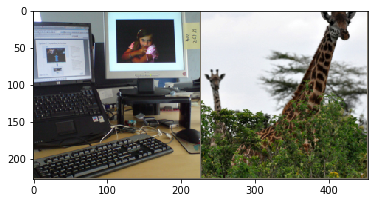

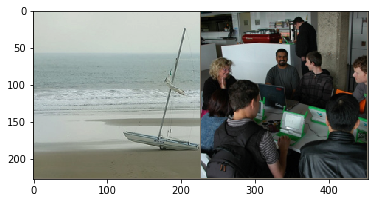

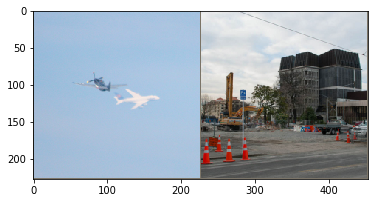

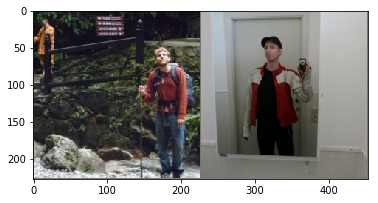

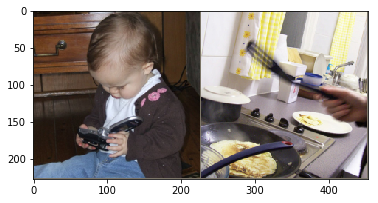

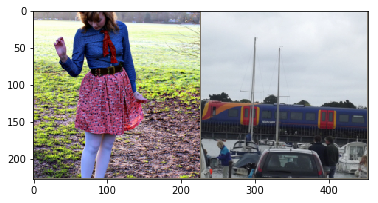

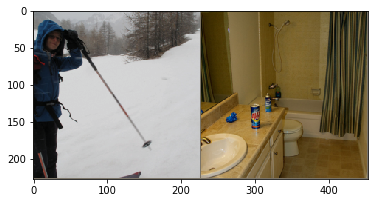

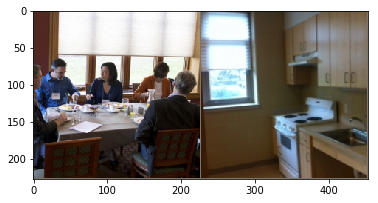

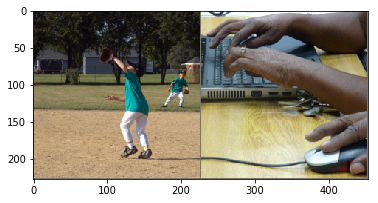

In [49]:
# for the PCA features
for idx, tuples in enumerate(knn_features_pca_list[10:20]):
    inputs = torch.FloatTensor(2,3,224,224)
    inputs[0] = images[idx+10].cpu()
    inputs[1] = images[tuples[1].cpu().numpy()[0]].cpu()
    out = torchvision.utils.make_grid(inputs, nrow=2)
    imshow(out)

#### Using the BLEU Score on the captions

In [50]:
from nltk.translate import bleu_score
from nltk import word_tokenize

In [51]:
pca_bleu_score = []
for idx, tuples in enumerate(knn_features_pca_list):
    match_index = tuples[1].cpu().numpy()[0]
    weights = [0.25, 0.25, 0.25, 0.25]
    score = []
    # for each caption in the selected image compute the bleu score with the 5 matched captions
    for caption in captions_list[idx]:
        candidate_tokens = word_tokenize(caption.replace('.',''))
        references_tokens = [word_tokenize(i.replace('.','')) for i in captions_list[match_index]] 
        score.append(bleu_score.sentence_bleu(references_tokens, candidate_tokens, weights))
    mean = np.mean(score)
    pca_bleu_score.append(mean)

/home/raille/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/raille/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/raille/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [52]:
np.mean(pca_bleu_score)

0.5749116458861171

In [53]:
raw_bleu_score = []
for idx, tuples in enumerate(knn_raw_features_list):
    match_index = tuples[1].cpu().numpy()[0]
    weights = [0.25, 0.25, 0.25, 0.25]
    score = []
    for caption in captions_list[idx]:
        candidate_tokens = word_tokenize(caption.replace('.',''))
        references_tokens = [word_tokenize(i.replace('.','')) for i in captions_list[match_index]] 
        score.append(bleu_score.sentence_bleu(references_tokens, candidate_tokens, weights))
    mean = np.mean(score)
    raw_bleu_score.append(mean)

/home/raille/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/raille/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/raille/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [54]:
np.mean(raw_bleu_score)

0.57501233454784428

The mean is slithgly higher on the raw feature set.